# EIT-CEM

In [14]:
#Fixing paths
import sys
sys.path.append('../../FEIT_codes') # Add the parent directory to the path list

#Importing modules
from FEIT_onefile import *
from math import pi
import scipy
import pickle
%matplotlib inline

## Mesh

In [30]:
"Definições Básicas do espaço."
r=14            #Radi
L=16           #Number of Electrodes
per_cober=0.454728409  #Perc. area of elec. on boundary
rotate=pi/2-0.0892857143183109       #Rotation

ele_pos=electrodes_position(L, per_cober, rotate, anticlockwise=False) #Eletrodes position object

## Checking electrode dimension

In [31]:
i=0
thetai=(ele_pos.position[i][0])
thetaf=(ele_pos.position[i][1])
elec_lenght=(thetaf-thetai)*r
print("Electrode {} lenght is: {} cm".format(i, elec_lenght))

Electrode 0 lenght is: 2.500000000912705 cm


N: 681, M: 160, K:1200


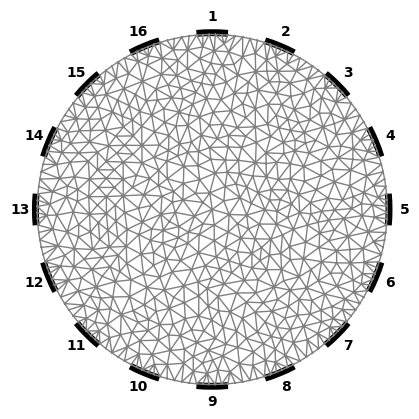

In [32]:
#input
refine_n=15 #Refinement parameter
n_in=6   #Number of vertex on electrodes
n_out=4   #Number of vertex on gaps

mesh=MyMesh(r=r, n=refine_n, n_in=n_in, n_out=n_out, electrodes_obj=ele_pos)
plot_electrodes(mesh, figsize=(5,5), fontsize=10)

#Mesh config
bmesh=BoundaryMesh(mesh, 'exterior', order=True)
print("N: {}, M: {}, K:{}".format(mesh.num_vertices(), bmesh.num_vertices(), mesh.num_cells()))

## Experiment data

In [33]:
solverconfig_dict= { 
            #General Parameters
            "step_limit": 50,
            "tau": 1.1,
            "weight_value": False,
            "innerstep_limit": 1,
            #General newton method parameters
            "mu_i":0.85,
            "mumax":0.999,
            "nu":0.98,
            "R":0.98,
            "z":np.ones(L)*0.07825,
            "background":0.92959,
}

In [34]:
#LM = Levenberg-Marquadt
list_exps = ["NTK","NLW"]
experiments = {}
for exp in list_exps: 
    experiments[exp] = {} 
    experiments[exp]["config"] = solverconfig_dict.copy()
    experiments[exp]["results"] = {}

#Newton-LM
experiments["NTK"]["config"]["inner_method"]="Tikhonov"
experiments["NTK"]["config"]["innerstep_limit"]=100
experiments["NTK"]["config"]["Tik_c0"]=0.005
experiments["NTK"]["config"]["Tik_q"]=1

#Newton-Landweber
experiments["NLW"]["config"]["inner_method"]="Landweber"
experiments["NLW"]["config"]["innerstep_limit"]=500
experiments["NLW"]["config"]["land_a"]=1



In [35]:
"Object"
data = ["datamat_1_2", "datamat_2_3", "datamat_4_1" ]
VD=FiniteElement('CG',mesh.ufl_cell(),1) #Espaço da solução
for dataname in data:
    #Load experimental data
    mat = scipy.io.loadmat("datamat/"+dataname)
    Uel=mat.get("Uel").T
    CP=mat.get("CurrentPattern").T

    #Selecting Potentials
    Uel_f=Uel[64:] #Matrix of measuarements
    Uel_converted=np.zeros_like(Uel_f)

    #Convert type of data
    for index, potential in enumerate(Uel_f): 
        Uel_converted[index]=ConvertingData(potential, method="KIT4")
    list_U0=Uel_converted.flatten() #Matrix to vector

    #Current
    I_all=CP[64:]/sqrt(2)
    l=np.shape(I_all)[0] #Number of experiments = 15

    #Noise Estiamtive
    delta = EstimateDelta(list_U0, I_all)
    noise_level_exp = delta/np.linalg.norm(list_U0)
    print("Noise level (%): ", noise_level_exp*100)

    for key, experiment in experiments.items():
        print(key)
        #if key!="NTK": continue
        z=experiment["config"]["z"]
        cond=experiment["config"]["background"]
        InverseObject=InverseProblem(mesh, list_U0, I_all, z)
        InverseObject.weight_value=False
        
        #First guess
        #cond=0.8866
        guess_r=np.ones(mesh.num_cells())*cond
        InverseObject.set_firstguess(guess_r)

        #"Solver Parameters"
        InverseObject.set_solverconfig(**experiment["config"], noise_level=noise_level_exp)

        #"Noise Parameters"
        tau=experiment["config"]["tau"]
        print(f"Discrepance stop {tau*noise_level_exp*100}% residue")

        #Call Solver
        InverseObject.solve_inverse()

        #Getting results
        experiment["results"]["res_vec"]=np.copy(InverseObject.res_vec)
        experiment["results"]["error_vec"]=np.copy(InverseObject.error_vec)
        experiment["results"]["gamma_k"]=InverseObject.gamma_all
        experiment["results"]["delta"]=noise_level_exp
        experiment["results"]["data0_vec"] = list_U0
        experiment["results"]["lastU0_vec"] = InverseObject.list_U

    save_it=True
    if save_it:
            for key, experiment in experiments.items():
                    with open('data/{}_{}.data'.format(dataname,key), 'wb') as config_dictionary_file:
                            pickle.dump(experiment, config_dictionary_file)

Noise level (%):  0.4235990100461563
NTK
Discrepance stop 0.465958911050772% residue
Residue (%)= 15.014031433679238  step: 0 Inner step:  0
mu_n 0.85
Residue (%)= 5.093419796425314  step: 1 Inner step:  1
mu_n 0.85
Residue (%)= 3.103636064767192  step: 2 Inner step:  1
mu_n 0.84915
Residue (%)= 2.569699840730388  step: 3 Inner step:  1
mu_n 0.84830085
Residue (%)= 2.185842622416698  step: 4 Inner step:  2
mu_n 0.923226274575
Residue (%)= 1.9810714462081978  step: 5 Inner step:  2
mu_n 0.922303048300425
Residue (%)= 1.773294684194847  step: 6 Inner step:  3
mu_n 0.9472538301680831
Residue (%)= 1.6673433597190108  step: 7 Inner step:  2
mu_n 0.9273804448111567
Residue (%)= 1.536796667638  step: 8 Inner step:  3
mu_n 0.9079240030790185
Residue (%)= 1.3692590482937224  step: 9 Inner step:  5
mu_n 0.9438096474455637
Residue (%)= 1.290204889106032  step: 10 Inner step:  3
mu_n 0.9240085210421558
Residue (%)= 1.1849475304460129  step: 11 Inner step:  5
mu_n 0.9046228222706914
Residue (%)= 1.


## Test section

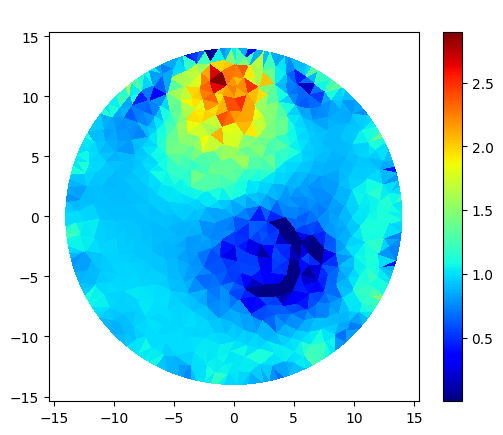

In [38]:
#Plot
Q_DG = FunctionSpace(mesh, "DG", 0)
gamma_k = Function(Q_DG)

gamma_k_vec=np.copy(experiments["NTK"]["results"]["gamma_k"][-1])
gamma_k.vector()[:]=gamma_k_vec#-np.log(gamma_k_vec)/np.log(cond)
gamma_k=plot_figure(gamma_k, name=" ", map='jet')

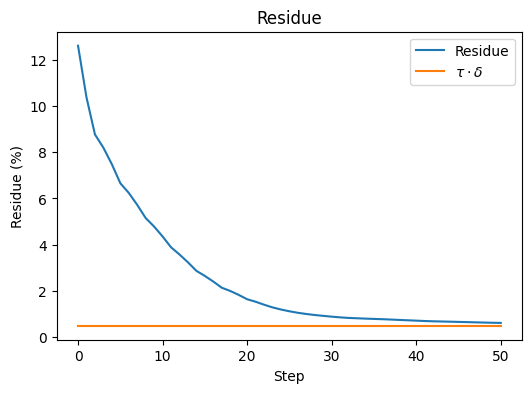

In [37]:
#Residue Curve
res=np.copy(InverseObject.res_vec)

plt.figure(figsize=(6, 4))
plt.ylabel('Residue (%)');
plt.xlabel('Step');
plt.title('Residue');
plt.plot()
plt.plot(res, label="Residue");
plt.plot(np.ones(len(res))*tau*noise_level_exp*100, label=r"$\tau \cdot \delta$");
plt.legend()
#plt.savefig("figures/{}/Residue.png".format(exp_name))
plt.show()